#### Analyze the results from decibel/scallop that are produced by `01A_run_decibel_with_subsampling.py`

- Ran with subsampling: Computes Euclidean, Manhattan, and correlation distance (using all genes or only invariant genes)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

from collections import Counter

from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
import os

In [2]:
cell_types = ["Adipocyte", "Cardiomyocyte", "Endocardial", "Endothelial",
              "Fibroblast", "LEC", "Myeloid", "Lymphoid", "Neuronal", 
              "Pericyte", "vSMC"]

num_cell_types = len(cell_types)

In [3]:
plots_dir = "../../../../paper_figures/"
os.makedirs(plots_dir, exist_ok=True)

In [4]:
results_dir = "decibel_results_with_subsampling/"
os.makedirs(results_dir,exist_ok=True)

In [5]:
euc_p_values = np.zeros(num_cell_types)
cor_p_values = np.zeros(num_cell_types)
scallop_p_values = np.zeros(num_cell_types)

euc_FC = np.zeros(num_cell_types)
cor_FC = np.zeros(num_cell_types)
scallop_FC = np.zeros(num_cell_types)

### Scallop noise

In [7]:
def test_scallop_contrast(contrast, group_A, group_B, num_of_cells = 100):

    '''Perform the entire scallop pipeline for a contrast, specifying two groups. Subsample to num_of_cells to compare.'''

    # iterate through all cell types
    for i in np.arange(num_cell_types):
        
        cell_type = cell_types[i]
        result_csv = results_dir + cell_type + "_adata_metadata.csv"

        try:
            results = pd.read_csv(result_csv)
        except Exception as e:
            print(f"Skipping {cell_type}: Error loading CSV - {e}")
            continue  # skip this cell type if file can't be loaded
    
        # sample specified number of cells from young and old
        group_1_results = results[results[contrast] == group_A]
        group_2_results = results[results[contrast] == group_B]

        num_group_1 = len(group_1_results)
        num_group_2 = len(group_2_results)

        # check if there are enough cells in both groups to sample
        if num_group_1 < num_of_cells or num_group_2 < num_of_cells:
            print(f"Skipping {cell_type}: Not enough cells (group_1: {num_group_1}, group_2: {num_group_2})")
            continue

        # otherwise, sample the specified number of cells from both groups
        sampled_group_1 = group_1_results.sample(num_of_cells)
        sampled_group_2 = group_2_results.sample(num_of_cells)
        
        # extract the noise metrics: Euclidean distance, correlation dist, scallop noise. 
        # perform Wilcoxon ranked sum test for each
        subsampled_group_1_euc_dist = sampled_group_1.euc_dist
        subsampled_group_2_euc_dist = sampled_group_2.euc_dist
        euc_FC[i] = np.mean(subsampled_group_2_euc_dist) / np.mean(subsampled_group_1_euc_dist)
        _, euc_p_values[i] = ranksums(subsampled_group_2_euc_dist, subsampled_group_1_euc_dist)
    
        subsampled_group_1_cor_dist = sampled_group_1.cor_dist
        subsampled_group_2_cor_dist = sampled_group_2.cor_dist
        cor_FC[i] = np.mean(subsampled_group_2_cor_dist) / np.mean(subsampled_group_1_cor_dist)
        _, cor_p_values[i] = ranksums(subsampled_group_2_cor_dist, subsampled_group_1_cor_dist)
    
        subsampled_group_1_scallop_noise = sampled_group_1.scallop_noise
        subsampled_group_2_scallop_noise = sampled_group_2.scallop_noise
        scallop_FC[i] = np.mean(subsampled_group_2_scallop_noise) / np.mean(subsampled_group_1_scallop_noise)
        _, scallop_p_values[i] = ranksums(subsampled_group_2_scallop_noise, subsampled_group_1_scallop_noise)
    
    # perform the multiple hypothesis testing
    adjusted_euc_p_values = multipletests(euc_p_values, method='fdr_bh')[1]
    adjusted_cor_p_values = multipletests(cor_p_values, method='fdr_bh')[1]
    adjusted_scallop_p_values = multipletests(scallop_p_values, method='fdr_bh')[1]

    # save the results in a dataframe
    overall_results_df = pd.DataFrame({'cell_type': cell_types,
                                'log_q_euc': -1 * np.log10(adjusted_euc_p_values),
                                'log_q_cor': -1 * np.log10(adjusted_cor_p_values) , 
                                'log_q_scallop': -1 * np.log10 (adjusted_scallop_p_values), 
                               'euc_FC': euc_FC, 
                               'cor_FC': cor_FC,
                               'scallop_FC': scallop_FC})
    
    # to make this tidy, keep just the cell_type and q values
    q_vals_df = overall_results_df[["cell_type", "log_q_euc", "log_q_cor", "log_q_scallop"]]
    q_vals_df_long = q_vals_df.melt(id_vars = "cell_type", value_vars = ["log_q_euc", "log_q_cor", "log_q_scallop"], 
                   var_name = "metric", value_name = "q_val")
    # remove "log_q_" from the metric
    q_vals_df_long['metric'] = q_vals_df_long['metric'].str.replace("log_q_", "")
    
    # do the same for the fold changes
    FC_vals_df = overall_results_df[["cell_type", "euc_FC", "cor_FC", "scallop_FC"]]
    FC_vals_df_long = FC_vals_df.melt(id_vars = "cell_type", value_vars = ["euc_FC", "cor_FC", "scallop_FC"], 
                                         var_name = "metric", value_name = "FC")
    # remove "_FC" from the metric
    FC_vals_df_long['metric'] = FC_vals_df_long['metric'].str.replace("_FC", "")
    
    # join them together to have a fully tidy df
    joined_long_df = FC_vals_df_long.merge(q_vals_df_long, on = ["cell_type", "metric"])

    center_value = 1
    # set max value to 10, so the colors are consistent
    norm = mcolors.TwoSlopeNorm(vmin=joined_long_df['q_val'].min(), 
                            vcenter=center_value, 
                            vmax=10)
    
    # use metric as the facet for plotting (to split by), do NOT share the same y axis
    g = sns.FacetGrid(joined_long_df, col='metric', height=4, aspect=1.5, margin_titles=True, sharey = False)
    
    # write the formula with cell_type on the x axis, FC on the x axis, and color based on the -log10(q)
    g.map(sns.stripplot, 'cell_type', 'FC', 'q_val', palette='coolwarm', hue_norm=norm, size=10)
    
    # for each facet, add horizontal line around 1 reflect no fold change
    for ax in g.axes.flat:
        ax.axhline(1, color='gray', linestyle='--', linewidth=1)
    
    # rotate x-axis labels for better visibility
    g.set_xticklabels(rotation=90)
    # tight layout to fit everything
    g.fig.tight_layout()

    # specify the color bar legend for the -log10(q)
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
    sm.set_array([])
    g.fig.colorbar(sm, label='-log10(adjusted p-val)', ax=g.axes, orientation='vertical', shrink=0.9)
    
    return [joined_long_df, g]

In [8]:
output_dir = "scallop_results/"
os.makedirs(output_dir, exist_ok=True)

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


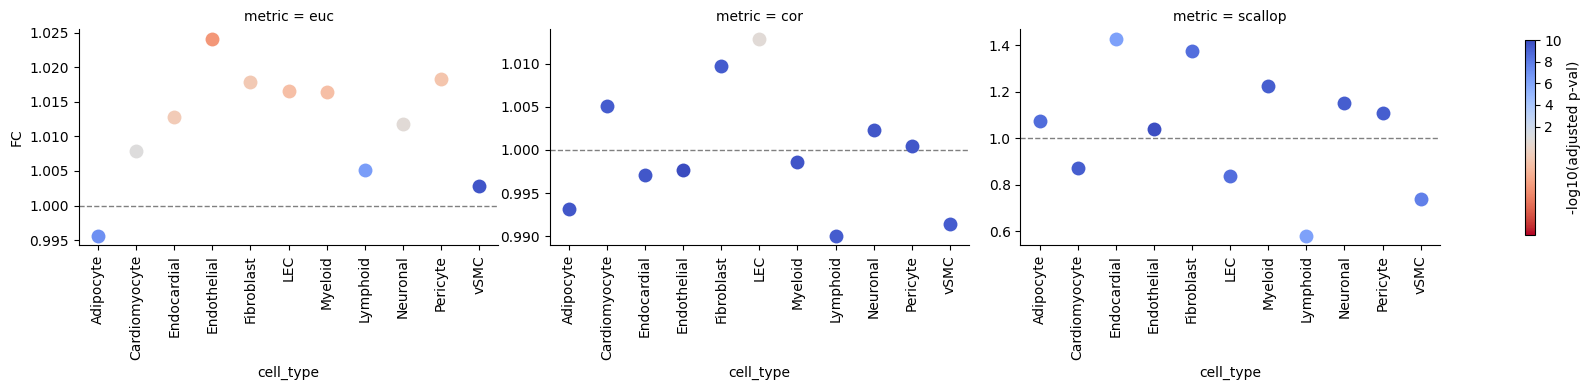

In [9]:
age_group_res_df, age_group_plot = test_scallop_contrast(contrast="age_group", group_A = "old", group_B = "young")
age_group_plot.savefig(plots_dir + "transcriptional_noise_age.pdf")
age_group_res_df['contrast'] = "aging"
age_group_res_df.to_csv(output_dir + "aging_results.csv")

Skipping Adipocyte: Not enough cells (group_1: 0, group_2: 3100)


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


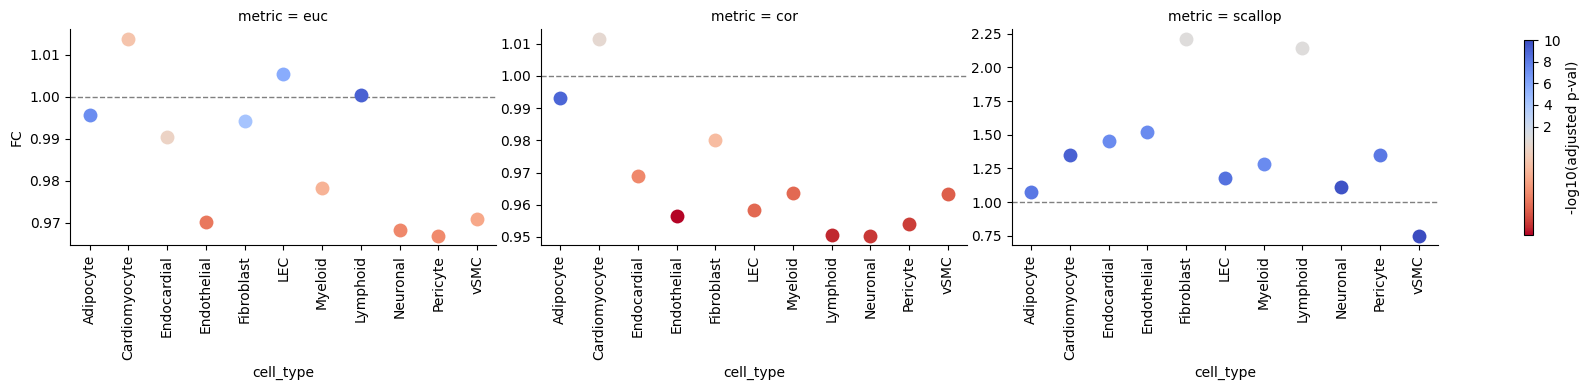

In [10]:
dev_group_res_df, dev_group_plot = test_scallop_contrast(contrast="age_status", group_A = "fetal", group_B = "postnatal")
dev_group_plot.savefig(plots_dir + "transcriptional_noise_development.pdf")
age_group_res_df['contrast'] = "development"
age_group_res_df.to_csv(output_dir + "development_results.csv")

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


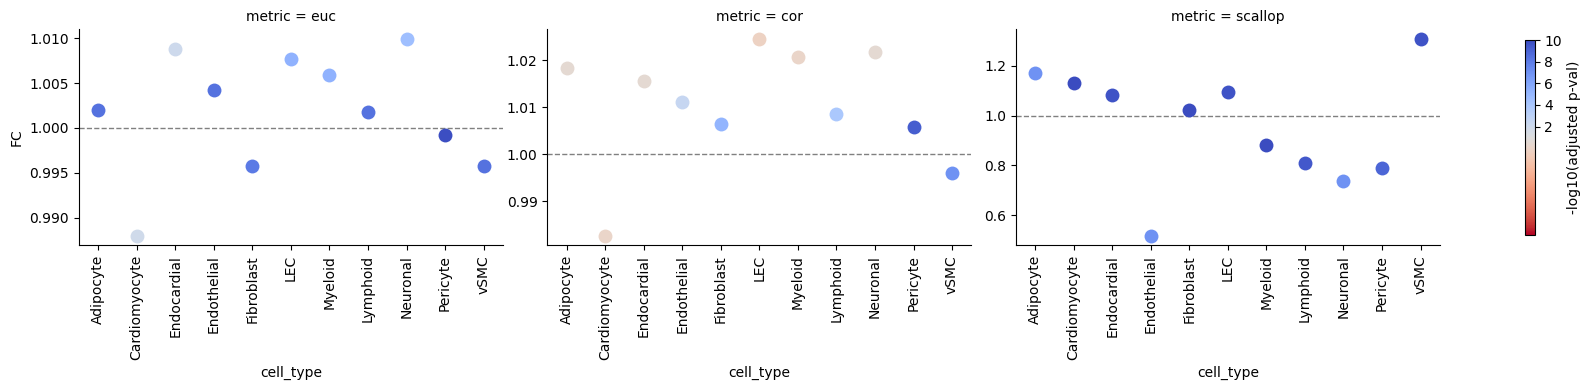

In [11]:
disease_res_df, disease_plot = test_scallop_contrast(contrast="disease_binary", group_A = "Y", group_B = "N")
disease_plot.savefig(plots_dir + "transcriptional_noise_disease.pdf")
disease_res_df['contrast'] = "disease"
disease_res_df.to_csv(output_dir + "disease_results.csv")

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


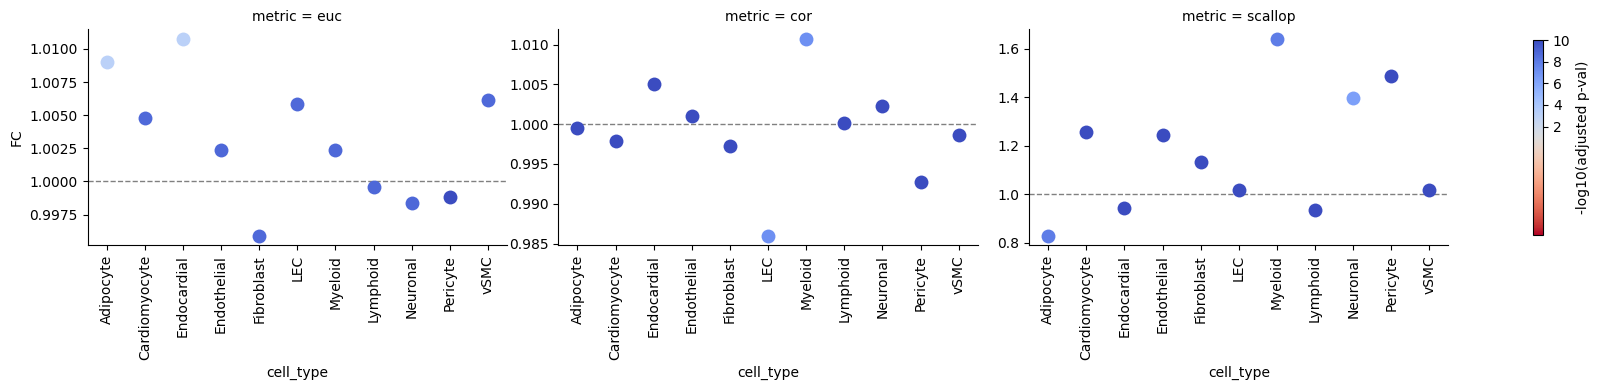

In [12]:
sex_res_df, sex_plot = test_scallop_contrast(contrast="sex", group_A = "male", group_B = "female")
sex_plot.savefig(plots_dir + "transcriptional_noise_sex.pdf")
sex_res_df['contrast'] = "sex"
sex_res_df.to_csv(output_dir + "sex_results.csv")